In [65]:
import sys
import ast
from pathlib import Path
from shapely import wkt  # type: ignore
import pandas as pd  # type: ignore
import geopandas as gpd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable  # type: ignore
import contextily as ctx  # type: ignore

# Add project root to path
project_root = Path().resolve().parents[4]
sys.path.insert(0, str(project_root))

from paths import *
import src.data_loader as dl
import src.optimization.experiments.helper_experiment as he
import src.optimization.helper_optimization as ho
import src.optimization.experiments.helper_experiment as he

ROOT = "../../../../.."

df, G, distance_matrix, id_to_idx, idx_to_id, _, STATION_MIN_DISTANCE = he.load_data(root=ROOT)

# Remove everything except node_id and geometry to generate synthetic data
df = df[['node_id', 'geometry']].set_index('node_id')

city_boundary = dl.load_bcn_boundary()

	Successfully loaded graph with protocol 5
Loading existing node attributes from ../../../../../data/raw/graph/node_attributes.csv
Loading pre-computed distance matrix and mappings...
	Successfully loaded mappings with protocol 5
Successfully loaded distance matrix of shape (18721, 18721)


# Plot functions

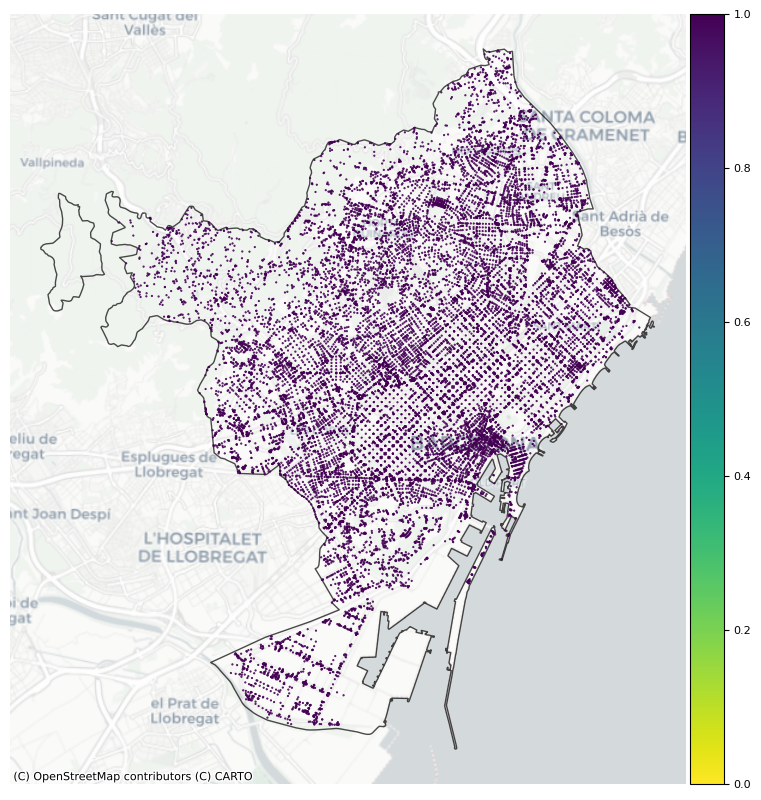

In [66]:
import networkx as nx
import matplotlib.cm as cm

def plot_all_nodes_map(G, city_boundary, df_weighted, ax, var):
    """
    Plot a map showing scores of all nodes.
    """
    # Get node positions
    pos = {node: (data.get('x'), data.get('y')) for node, data in G.nodes(data=True)}
    
    # Plot boundary
    city_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.7)
    
    # Get all nodes and their scores
    all_nodes = list(G.nodes())
    node_scores = [df_weighted.loc[node, var] for node in all_nodes]
    
    # Draw all nodes with colors based on scores
    scatter = nx.draw_networkx_nodes(G, pos, nodelist=all_nodes,
                                   node_color=node_scores,
                                   cmap=cm.viridis_r,
                                   vmin=0, vmax=1,
                                   node_size=0.3,
                                   ax=ax)
    
    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    
    # Add basemap
    if 'crs' in G.graph:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=G.graph['crs'], zoom=12)

    ax.set_axis_off()
    
    return ax

# Synthetic data generation functions


In [67]:
import numpy as np

In [98]:
from networkx.algorithms.community import greedy_modularity_communities

# Define a dispatcher of strategies
def assign_uniform(G):
    """Uniform random in [0,1]."""
    return {u: np.random.rand() for u in G.nodes()}

def assign_dist_center(G, center=(429030.279, 4583487.198)):
    """normalized Euclidean distance from center."""
    cx, cy = center
    # Get bounds of graph nodes to normalize distances
    xs = [data['x'] for _, data in G.nodes(data=True)]
    ys = [data['y'] for _, data in G.nodes(data=True)]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # Maximum possible distance from center to any corner
    corners = [(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)]
    max_d = max(np.hypot(x - cx, y - cy) for x, y in corners)
    
    vals = {}
    for u, data in G.nodes(data=True):
        x, y = data['x'], data['y']  # Access x,y directly instead of using pos
        d = np.hypot(x - cx, y - cy)
        vals[u] = 1 - min(d / max_d, 1)
    return vals

def assign_inv_dist_center(G, center=(429030.279, 4583487.198)):
    """inverse normalized Euclidean distance from center."""
    cx, cy = center
    # Get bounds of graph nodes to normalize distances
    xs = [data['x'] for _, data in G.nodes(data=True)]
    ys = [data['y'] for _, data in G.nodes(data=True)]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # Maximum possible distance from center to any corner
    corners = [(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)]
    max_d = max(np.hypot(x - cx, y - cy) for x, y in corners)
    
    vals = {}
    for u, data in G.nodes(data=True):
        x, y = data['x'], data['y']  # Access x,y directly instead of using pos
        d = np.hypot(x - cx, y - cy)
        vals[u] = min(d / max_d, 1)  # Removed the 1- to invert the values
    return vals
    

def assign_community_plateaus(G):
    """Assign a plateau value per community in [0,1]."""
    comms = list(greedy_modularity_communities(G))
    if len(comms) == 1:
        return {u: 0.5 for u in G.nodes()}
    vals = {}
    for i, comm in enumerate(comms):
        v = i / (len(comms) - 1)
        for u in comm:
            vals[u] = v
    return vals

strategies = {
    'uniform': assign_uniform,
    'distance_center': assign_dist_center,
    'inv_distance_center': assign_inv_dist_center,
    'community': assign_community_plateaus,
}

In [96]:
def apply_strategy(G, nodes_gdf, strategy_name):
    """
    Apply the named strategy to G and nodes_gdf,
    storing the result under attribute/column 'demand'.
    """
    if strategy_name not in strategies:
        raise ValueError(f"Unknown strategy '{strategy_name}'")
    # compute the new values
    values = strategies[strategy_name](G)
    # 1) assign to G
    nx.set_node_attributes(G, values, name=strategy_name)
    # 2) assign to GeoDataFrame
    #    assumes nodes_gdf.index aligns with G.nodes()
    nodes_gdf[strategy_name] = nodes_gdf.index.map(values)
    return G, nodes_gdf


uniform
distance_center
inv_distance_center
community


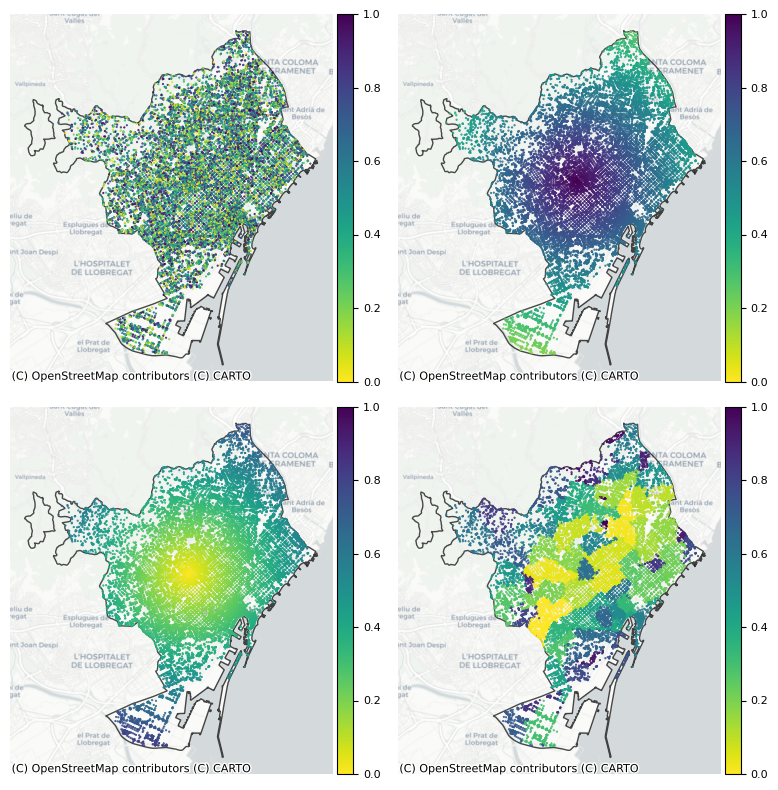

: 

In [ ]:
for strategy in strategies:
    print(strategy)
    G, df = apply_strategy(G, df, strategy)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for i, strategy in enumerate(strategies):
    ax = axs[i]
    plot_all_nodes_map(G, city_boundary, df, ax, strategy)

plt.tight_layout()
plt.show()
